# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science



## Group #20: Final Project - World Cup Predictions 

**Harvard University**<br>
**Fall 2018**<br>
**Group Members:** <br>

In [41]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set()
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold

In [8]:
from IPython.display import display, HTML

In [12]:
X = pd.read_csv('data/team/project_data_v2.csv', index_col='Unnamed: 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1787 entries, 0 to 1786
Data columns (total 31 columns):
date             1787 non-null object
home_team        1787 non-null object
away_team        1787 non-null object
home_score       1787 non-null int64
away_score       1787 non-null int64
tournament       1787 non-null object
city             1787 non-null object
country          1787 non-null object
neutral          1787 non-null int64
home_rank        1787 non-null int64
home_rank_pts    1787 non-null int64
away_rank        1787 non-null int64
away_rank_pts    1787 non-null int64
rank_diff        1787 non-null int64
rank_pts_diff    1787 non-null int64
outcome          1787 non-null object
outcome_num      1787 non-null int64
home_game        1787 non-null int64
away_game        1787 non-null int64
home_OVR         1787 non-null int64
home_ATT         1787 non-null int64
home_MID         1787 non-null int64
home_DEF         1787 non-null int64
home_team_id     1787 non-null int6

In [73]:
#X['date'] = pd.to_datetime(X['date'])
#X = X.drop(['home_team_id', 'home_team_url', 'away_team_id', 'away_team_url'], axis=1)
X['OVR_diff'] = X['home_OVR'] - X['away_OVR']
X['ATT_diff'] = X['home_ATT'] - X['away_ATT']
X['MID_diff'] = X['home_MID'] - X['away_MID']
X['DEF_diff'] = X['home_DEF'] - X['away_DEF']
X['Friendly'] = [1 if x == 'Friendly' else 0 for x in X['tournament']]

X['home-att-away-defense'] = X['home_ATT'] - X['away_DEF']
X['home-defense-away-att'] = X['home_DEF'] - X['away_ATT']
#X['diff-att-defense'] = X['home-att-away-defense'] - X['away-att-home-defense']


X.tail()






,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_rank,home_rank_pts,away_rank,away_rank_pts,rank_diff,rank_pts_diff,outcome,outcome_num,home_game,away_game,home_OVR,home_ATT,home_MID,home_DEF,away_OVR,away_ATT,away_MID,away_DEF,OVR_diff,ATT_diff,MID_diff,DEF_diff,Friendly,home-att-away-defense,away-att-home-defense,diff-att-defense,home-defense-away-att
1782,2018-07-07,Russia,Croatia,2,2,FIFA World Cup,Sochi,Russia,0,70,457,20,945,50,-488,D,1,1,0,79,80,78,77,80,80,82,78,-1,0,-4,-1,0,2,3,-1,-3
1783,2018-07-10,France,Belgium,1,0,FIFA World Cup,St. Petersburg,Russia,1,7,1198,3,1298,4,-100,W,0,0,0,85,86,84,81,83,84,82,84,2,2,2,-3,0,2,3,-1,-3
1784,2018-07-11,Croatia,England,2,1,FIFA World Cup,Moscow,Russia,1,20,945,12,1051,8,-106,W,0,0,0,80,80,82,78,81,83,81,80,-1,-3,1,-2,0,0,5,-5,-5
1785,2018-07-14,Belgium,England,2,0,FIFA World Cup,St. Petersburg,Russia,1,3,1298,12,1051,-9,247,W,0,0,0,83,86,81,84,81,83,81,80,2,3,0,4,0,6,-1,7,1
1786,2018-07-15,France,Croatia,4,2,FIFA World Cup,Moscow,Russia,1,7,1198,20,945,-13,253,W,0,0,0,85,86,84,81,80,80,82,78,5,6,2,3,0,8,-1,9,1


In [127]:
train_data = X[(X['date'] <= '2018-06-13') & (X['tournament'] != 'Friendly')]
test_data = X[(X['date'] > '2018-06-13') & (X['tournament'] != 'Friendly')]

In [128]:
train_data.head(30)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_rank,home_rank_pts,away_rank,away_rank_pts,rank_diff,rank_pts_diff,outcome,outcome_num,home_game,away_game,home_OVR,home_ATT,home_MID,home_DEF,away_OVR,away_ATT,away_MID,away_DEF,OVR_diff,ATT_diff,MID_diff,DEF_diff,Friendly,home-att-away-defense,away-att-home-defense,diff-att-defense,home-defense-away-att
5,2010-08-15,Uruguay,Argentina,3,1,Copa Lipton,Montevideo,Uruguay,0,6,1152,5,1288,1,-136,W,0,1,0,78,83,74,79,83,85,81,80,-5,-2,-7,-1,0,3,6,-3,-6
10,2010-11-13,Argentina,Uruguay,1,1,Copa Premio Honor Argentino,Buenos Aires,Argentina,0,5,1288,6,1152,-1,136,D,1,1,0,83,87,82,79,79,84,75,77,4,3,7,2,0,10,5,5,-5
11,2010-11-27,Argentina,Uruguay,2,6,Copa Premio Honor Argentino,Buenos Aires,Argentina,0,5,1353,7,1174,-2,179,L,2,1,0,83,87,82,79,79,84,75,77,4,3,7,2,0,10,5,5,-5
15,2011-01-28,Northern Ireland,Wales,1,2,British Championship,Belfast,Ireland,0,43,615,113,261,-70,354,L,2,0,0,71,71,69,72,73,75,75,72,-2,-4,-6,0,0,-1,3,-4,-3
16,2011-02-11,England,Northern Ireland,2,1,British Championship,Derby,England,0,6,1195,43,615,-37,580,W,0,1,0,84,85,83,84,71,71,69,72,13,14,14,12,0,13,-13,26,13
17,2011-03-06,Wales,Scotland,2,2,British Championship,Cardiff,Wales,0,113,261,52,542,61,-281,D,1,1,0,73,75,75,72,75,74,76,72,-2,1,-1,0,0,3,2,1,-2
18,2011-03-13,England,Wales,3,0,British Championship,London,England,0,6,1195,113,261,-107,934,W,0,1,0,84,85,83,84,73,75,75,72,11,10,8,12,0,13,-9,22,9
19,2011-03-18,Scotland,Northern Ireland,2,0,British Championship,Glasgow,Scotland,0,52,542,43,615,9,-73,W,0,1,0,75,74,76,72,71,71,69,72,4,3,7,0,0,2,-1,3,1
22,2011-04-01,England,Scotland,1,1,British Championship,Liverpool,England,0,6,1195,52,542,-46,653,D,1,1,0,84,85,83,84,75,74,76,72,9,11,7,12,0,13,-10,23,10
32,2011-08-15,Argentina,Uruguay,0,2,Copa Lipton,Buenos Aires,Argentina,0,5,1267,7,1094,-2,173,L,2,1,0,83,87,82,79,79,84,75,77,4,3,7,2,0,10,5,5,-5


In [129]:
num_cols = ['OVR_diff', 'ATT_diff', 'MID_diff', 'DEF_diff', 'rank_pts_diff']
    
def wc_box(df, cols):
        
    ## Loop over the columns and create the box plots
    for col in cols:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column = col, by = 'outcome', vert=False, ax = ax)        
        ax.set_xlabel(col)
        ax.set_ylabel('Outcome of the Match')
        ax.set_title('Outcome vs. ' + col)  

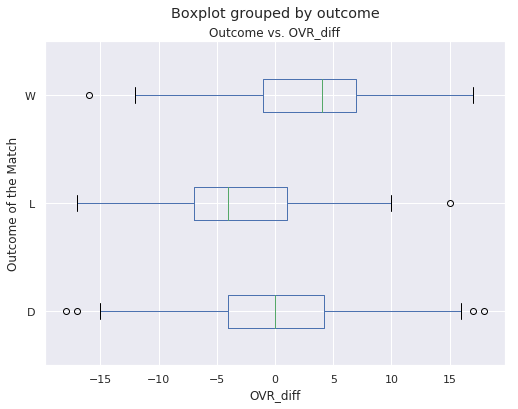

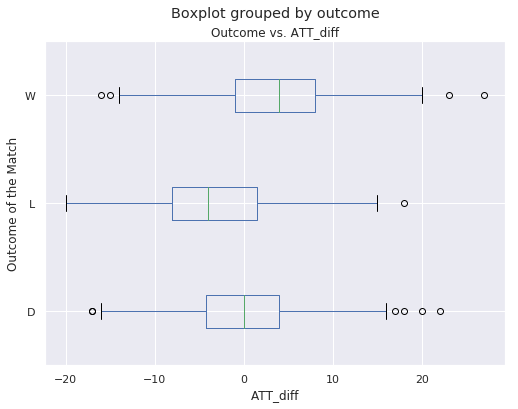

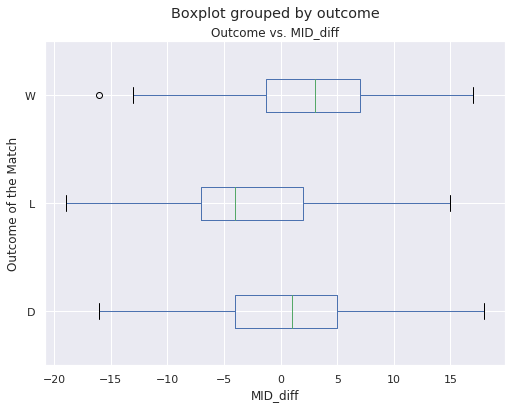

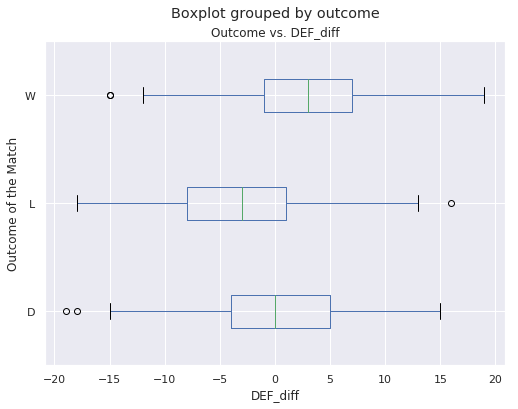

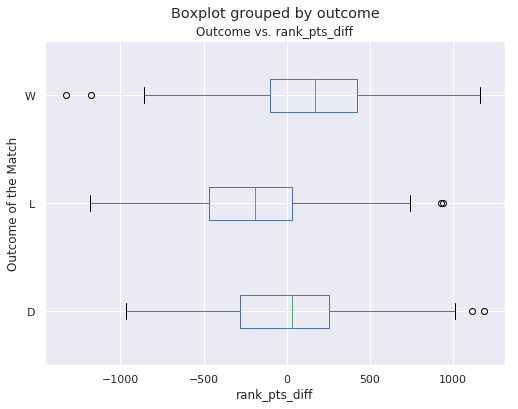

In [130]:
wc_box(train_data, num_cols)

**If the difference between the home and away teams' skill levels or ranking points approaches 0, the match is likely to be drawn. But if the difference is more than 0, then the home team is likely to win, whereas if the difference is less than 0, then the home team is likely to loose the game. In short, as expected, the stronger team on paper is more likely to win the match.**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

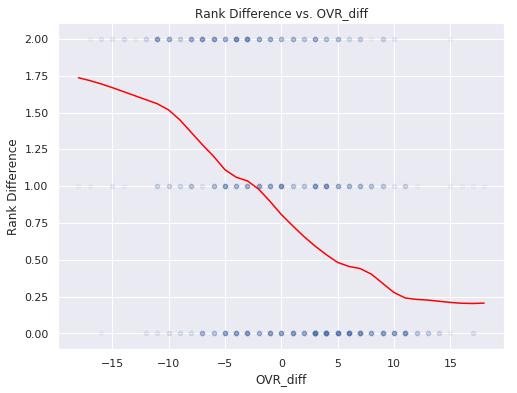

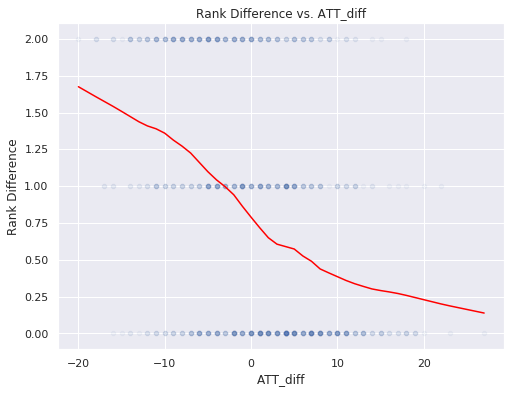

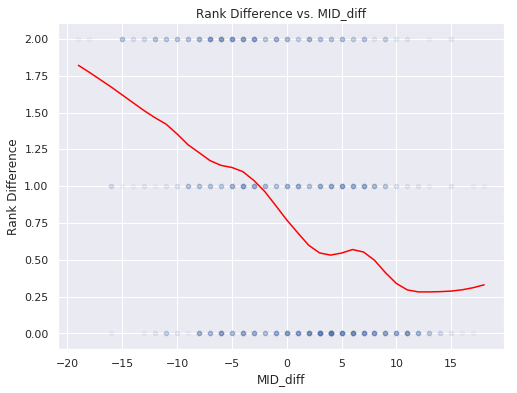

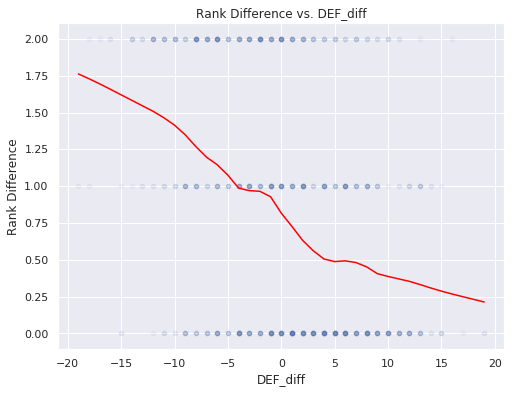

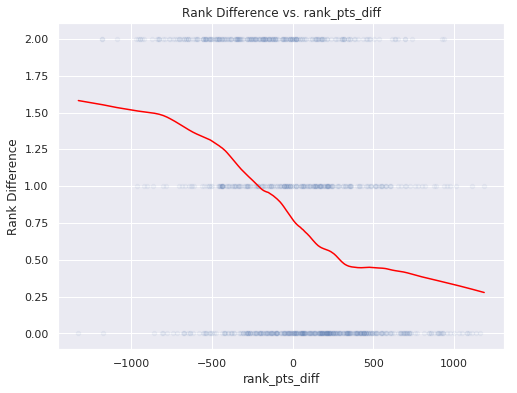

In [131]:
#num_cols = ['OVR_diff', 'ATT_diff', 'MID_diff', 'DEF_diff', 'rank_pts_diff']

def wc_scatter(df, cols):
    import statsmodels.nonparametric.smoothers_lowess as lw
    
    ## Loop over the columns and create the scatter plots
    for col in cols:
        ## first compute a lowess fit to the data
        los = lw.lowess(df['outcome_num'], df[col], frac = 0.3)
    
        ## Now make the plots
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df.plot(kind = 'scatter', x = col, y = 'outcome_num', ax = ax, alpha = 0.05)
        plt.plot(los[:, 0], los[:, 1], axes = ax, color = 'red')
        ax.set_xlabel(col)
        ax.set_ylabel('Rank Difference')
        ax.set_title('Rank Difference vs. ' + col)
        
wc_scatter(train_data, num_cols)

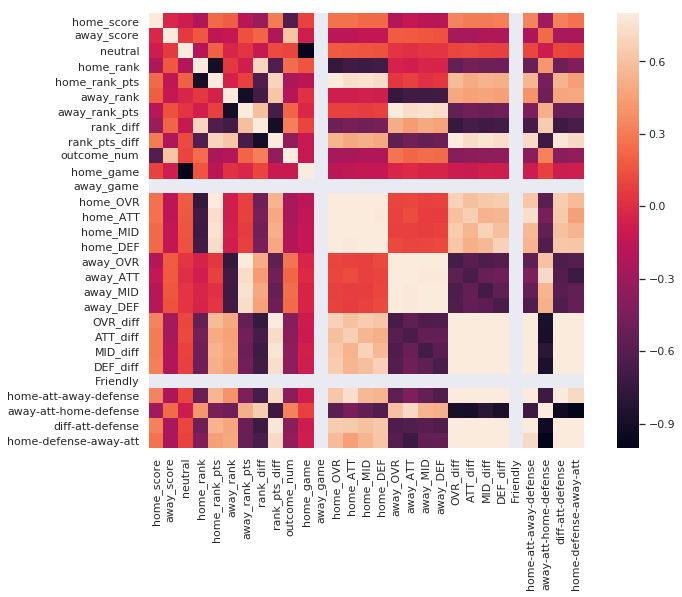

In [132]:
# Setting up the correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=.8, square=True);

**As expected, we can clearly see that there's a very strong correlation between the ranks and rank points. We can also see that rank and team statistics are strongly correlated so, for example, home_rank and home_OVR are strongly correlated. Similarly, rank_diff and OVR_diff are strongly correlated.**

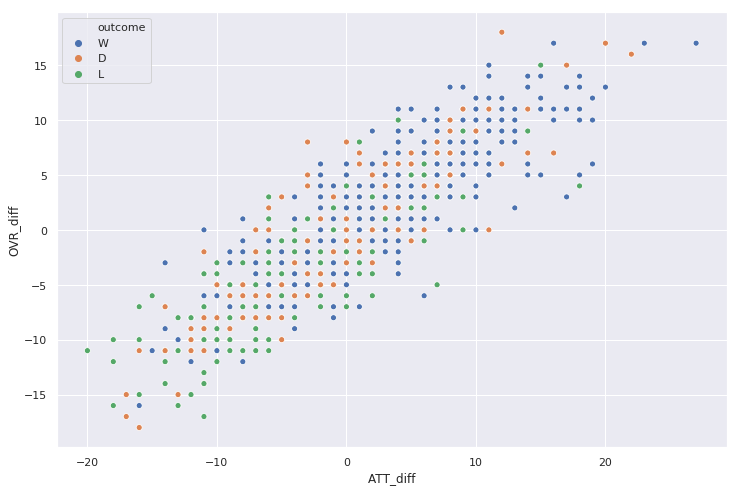

In [133]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax=sns.scatterplot(train_data.ATT_diff, train_data.OVR_diff, hue=train_data.outcome)

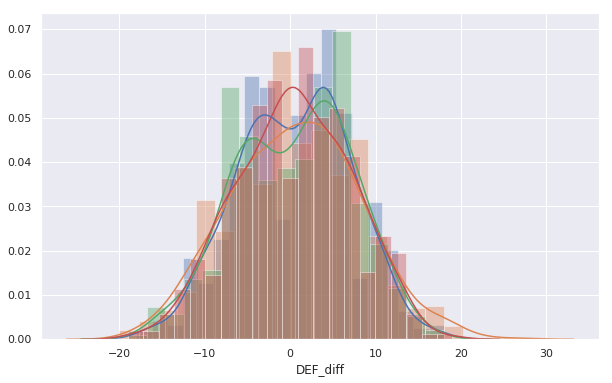

In [134]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax=sns.distplot(train_data.OVR_diff)
ax=sns.distplot(train_data.ATT_diff)
ax=sns.distplot(train_data.MID_diff)
ax=sns.distplot(train_data.DEF_diff);

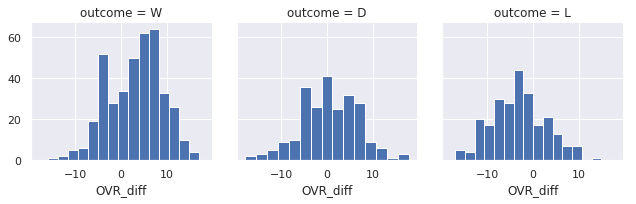

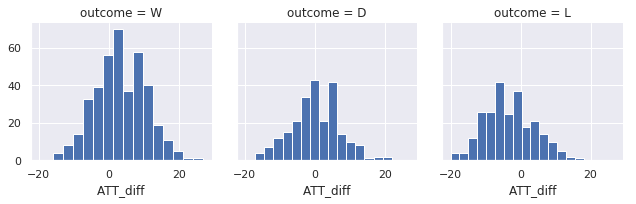

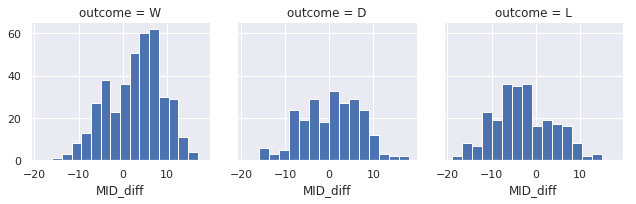

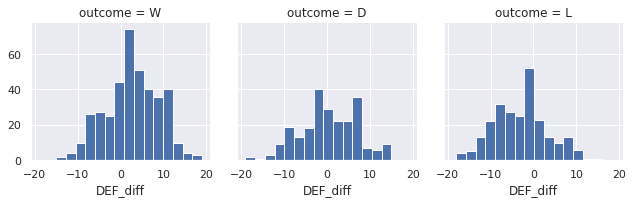

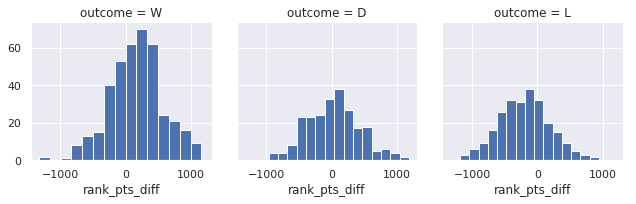

In [135]:
for item in num_cols:
    g = sns.FacetGrid(train_data, col="outcome")
    g = (g.map(plt.hist, item, bins=15))

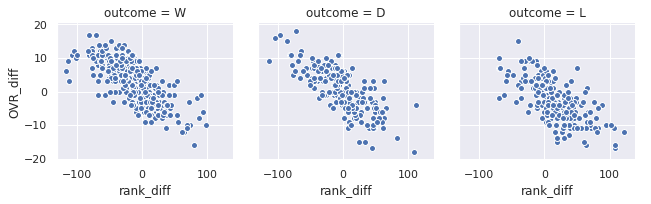

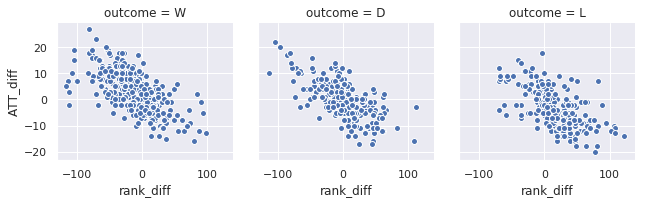

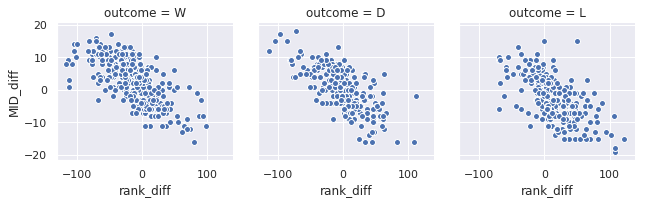

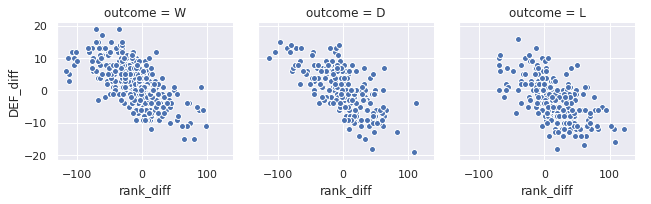

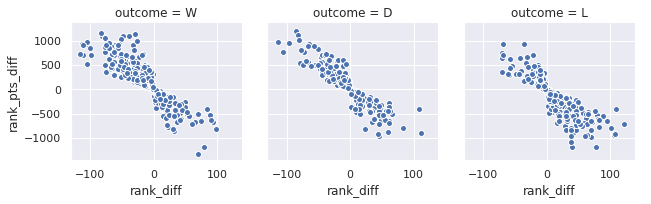

In [136]:
for item in num_cols:
    g = sns.FacetGrid(train_data, col="outcome")
    g = (g.map(plt.scatter, 'rank_diff', item, edgecolor='w').add_legend())

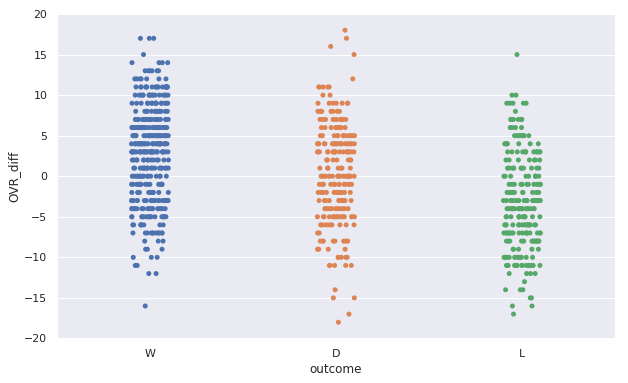

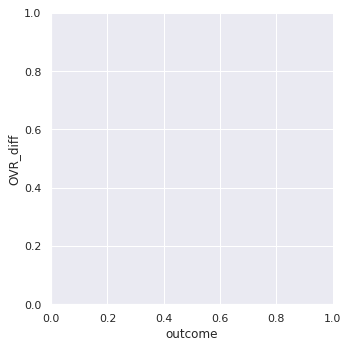

In [137]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.catplot(x='outcome', y='OVR_diff', data=train_data, ax=ax)

In [138]:
# define the feature set for our base model
#X['home-att-away-defense'] = X['home_ATT'] - X['away_DEF']
#X['away-att-home-defense'] = X['away_ATT'] - X['home_DEF']
#X['diff-att-defense'] = X['home-att-away-defense'] - X['away-att-home-defense']

#X['home-att-away-defense'] = X['home_ATT'] - X['away_DEF']
#X['home-defense-away-att'] = X['home_DEF'] - X['away_ATT']

predictors = ['rank_pts_diff' , 'OVR_diff',  'MID_diff',  \
              'home-att-away-defense', 'home-defense-away-att'] # 'ATT_diff','DEF_diff',

# scale the features
def scale_df(df, means, stds):
    cols_to_scale = means.index
    df = df.copy()
    df[cols_to_scale] = (df[cols_to_scale] - means) / stds
    return df

cols_to_scale = predictors
train_means = train_data[cols_to_scale].mean(axis=0)
train_stds = train_data[cols_to_scale].std(axis=0)

train_data = scale_df(train_data, train_means, train_stds)
test_data = scale_df(test_data, train_means, train_stds)

# define x_train, y_train and x_test, y_test
x_train, y_train = train_data[predictors], train_data['outcome_num']
x_test, y_test = test_data[predictors], test_data['outcome_num']

display(x_train.describe())
display(x_test.describe())

,rank_pts_diff,OVR_diff,MID_diff,home-att-away-defense,home-defense-away-att
count,8.790000e+02,8.790000e+02,8.790000e+02,8.790000e+02,8.790000e+02
mean,-2.230866e-17,1.335678e-17,1.401988e-17,-1.465141e-17,-7.906708e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.155474e+00,-2.844388e+00,-2.831804e+00,-2.758641e+00,-2.722496e+00
25%,-6.779609e-01,-6.904874e-01,-7.915124e-01,-7.234640e-01,-6.573649e-01
50%,-2.275558e-03,7.876282e-02,8.289824e-02,-4.507179e-02,3.101221e-02
75%,6.570720e-01,6.941630e-01,8.115738e-01,7.689988e-01,7.193893e-01
max,2.716804e+00,2.694214e+00,2.560395e+00,2.939854e+00,2.646845e+00


,rank_pts_diff,OVR_diff,MID_diff,home-att-away-defense,home-defense-away-att
count,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.045206,0.122033,0.092007,0.035487,0.185897
std,0.943282,0.977836,0.942640,0.904432,1.007382
min,-2.420272,-2.075138,-2.248864,-1.944570,-1.758768
25%,-0.635366,-0.690487,-0.536476,-0.519946,-0.519689
50%,0.022231,0.155688,0.082898,0.090607,0.099850
75%,0.735844,0.848013,0.811574,0.667240,0.891484
max,1.759874,2.078813,1.977455,1.854426,2.371494


In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

splitter = StratifiedKFold(5, random_state=42, shuffle=True) 

# fit logistic regression
simple_logistic_model = LogisticRegressionCV(multi_class = 'ovr', cv=splitter, penalty='l2')
simple_logistic_model.fit(x_train, y_train)
print('Logistic Regression Train Score: ',simple_logistic_model.score(x_train, y_train))
print('Logistic Regression CV Train Score: ',cross_val_score(simple_logistic_model, x_train, y_train, cv=5).mean())

Logistic Regression Train Score:  0.516496018203
Logistic Regression CV Train Score:  0.510817962936


In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# fit lda and qda 
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)


splitter = StratifiedKFold(5, random_state=42, shuffle=True) 

print('LDA Train Score: ',lda.score(x_train, y_train))
print('LDA CV Train Score: ',cross_val_score(lda, x_train, y_train, cv=splitter).mean())
print('QDA Train Score: ',qda.score(x_train, y_train))
print('QDA CV Train Score: ',cross_val_score(qda, x_train, y_train, cv=splitter).mean())

LDA Train Score:  0.524459613197
LDA CV Train Score:  0.517630745659
QDA Train Score:  0.515358361775
QDA CV Train Score:  0.501772289508


In [141]:
# choosing lda and qda as they both produced very similar scores on CV data
print('LDA Test Score: ',simple_logistic_model.score(x_test, y_test))
print('LDA Test Score: ',lda.score(x_test, y_test))
print('QDA Test Score: ',qda.score(x_test, y_test))

LDA Test Score:  0.59375
LDA Test Score:  0.5625
QDA Test Score:  0.546875


In [142]:
# confusion matrix for the lda model
pd.crosstab(np.array(y_test), lda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,All
Actual,,,,
0,23,0,3,26
1,11,0,2,13
2,11,1,13,25
All,45,1,18,64


In [143]:
# confusion matrix for the qda model
pd.crosstab(np.array(y_test), qda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,All
Actual,,,,
0,24,0,2,26
1,11,0,2,13
2,13,1,11,25
All,48,1,15,64


In [144]:
# confusion matrix for the logistic model
pd.crosstab(np.array(y_test), simple_logistic_model.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,2,All
Actual,,,
0,24,2,26
1,11,2,13
2,11,14,25
All,46,18,64


In [145]:
x_train

,rank_pts_diff,OVR_diff,MID_diff,home-att-away-defense,home-defense-away-att
5,-0.371043,-0.844337,-1.082983,-0.045072,-0.519689
10,0.263797,0.540313,0.957309,0.904677,-0.382014
11,0.364158,0.540313,0.957309,0.904677,-0.382014
15,0.772604,-0.382787,-0.937248,-0.587786,-0.106663
16,1.300082,1.924963,1.977455,1.311713,2.096144
17,-0.709470,-0.382787,-0.208572,-0.045072,0.031012
18,2.126308,1.617263,1.103044,1.311713,1.545442
19,-0.224003,0.540313,0.957309,-0.180750,0.444038
22,1.470462,1.309563,0.957309,1.311713,1.683117
32,0.350154,0.540313,0.957309,0.904677,-0.382014
